In [1]:
from functools import partial

import lightgbm
import matplotlib.pyplot as plt
import numpy as np
import sklearn, sklearn.linear_model

import loader
from models import BinningCalibrator
import utils

split_ratio_test = 0.3
split_ratio_postproc = 0.5  # among all training data

# These seeds control the randomness for the post-process/test split and in
# postprocessing.  It does not affect pre-training data nor the randomness in
# pre-training, i.e., we assume the pre-trained predictor to be fixed.  Results
# will be aggregated over the seeds.
seeds = range(33, 38)

# This seed controls the randomness during pre-training (fixed)
seed_pretrain = 33

# Settings for calibration
n_bins_calib = 5
prior_strength_calib = 1
calibrator_factory = partial(BinningCalibrator,
                             n_bins=n_bins_calib,
                             prior_strength=prior_strength_calib)

max_workers = 32

data_dir = "data/compas"

In [2]:
## Load ProPublica COMPAS dataset

(inputs_df, labels, label_names, groups,
 group_names) = loader.load_compas(data_dir)
inputs_u_df = loader.load_compas(data_dir, remove_sensitive_attr=True)[0]
      
display(loader.dataset_stats(labels, label_names, groups, group_names))

n_classes = len(label_names)
n_groups = len(group_names)

inputs = np.array(inputs_df.values, dtype=np.float32)
inputs_u = np.array(inputs_u_df.values, dtype=np.float32)

Group,African-American,Caucasian
Target,,
No,1402,1229
Yes,1773,874


In [3]:
## Split data into (test + post-processing) and pre-training sets

(inputs_, inputs_pretrain, inputs_u_, inputs_u_pretrain, labels_,
 labels_pretrain, groups_,
 groups_pretrain) = sklearn.model_selection.train_test_split(
     inputs,
     inputs_u,
     labels,
     groups,
     test_size=(1 - split_ratio_test) * (1 - split_ratio_postproc),
     random_state=seed_pretrain,
 )

# Encode the joint (A, Y) labels by flattening
labels_ay_pretrain = groups_pretrain * n_classes + labels_pretrain

# Normalize data
scaler = sklearn.preprocessing.StandardScaler()
inputs_pretrain = scaler.fit_transform(inputs_pretrain)
inputs_ = scaler.transform(inputs_)

scaler = sklearn.preprocessing.StandardScaler()
inputs_u_pretrain = scaler.fit_transform(inputs_u_pretrain)
inputs_u_ = scaler.transform(inputs_u_)

n_samples = len(inputs)
n_test = int(n_samples * split_ratio_test)

## Logistic regression

In [4]:
# Train attribute-aware p(Y | X) predictor
predictor_y = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = sklearn.linear_model.LogisticRegression(
    max_iter=10000, random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.1736307414970163


In [5]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

Code for post-processing a single model (with precomputed probas):

    postprocessor = postprocess.PostProcessor(
        n_classes,
        n_groups,
        pred_ay_fn=lambda x: x,  # dummy pred_fn
        criterion='sp',
        alpha=alpha,
        seed=seed,
    )
    postprocessor.fit(probas_ay_postproc)
    preds = postprocessor.predict(probas_ay_test)


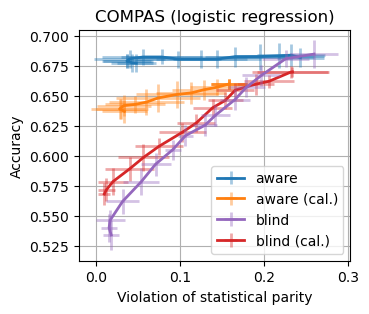

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.243296  0.028292
0.240  0.684018  0.009427  0.232082  0.040717
0.220  0.683512  0.010542  0.217679  0.053186
0.200  0.682881  0.010841  0.194874  0.064948
0.180  0.682754  0.008397  0.165456  0.060369
0.160  0.680733  0.007719  0.143957  0.052160
0.140  0.680733  0.007588  0.125169  0.054170
0.120  0.680733  0.007043  0.098253  0.050534
0.100  0.682502  0.006247  0.078299  0.048257
0.080  0.682502  0.006544  0.056251  0.048536
0.060  0.680985  0.007407  0.040181  0.041927
0.040  0.679217  0.006033  0.037413  0.030154
0.020  0.679217  0.005882  0.036892  0.028909
0.010  0.677574  0.007321  0.043249  0.025177
0.001  0.677322  0.007559  0.048114  0.023344

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.660013  0.004270  0.158510  0.021157
0.240  0.660013  0.004270  0.158510  0.021157
0.220  0.660013  0.004270  0.158510  0.021157
0.200  0.660013  0.004270  0.158510  0.021157
0.180  0.657359  0.006513  0.144553  0.032251
0.160  0.655212  0.008338  0.128578  0.038071
0.140  0.652558  0.009444  0.113469  0.041742
0.120  0.651295  0.011380  0.096892  0.048662
0.100  0.648389  0.011602  0.074241  0.049744
0.080  0.644852  0.010621  0.060083  0.044695
0.060  0.642956  0.007426  0.046680  0.035566
0.040  0.641946  0.008632  0.033030  0.032282
0.020  0.639166  0.008701  0.028158  0.033380
0.010  0.638913  0.008159  0.029371  0.028863
0.001  0.637145  0.009690  0.033940  0.026897

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.259447  0.028586
0.240  0.681112  0.007167  0.225851  0.027809
0.220  0.667088  0.009023  0.196656  0.022283
0.200  0.657107  0.008373  0.178759  0.022066
0.180  0.646873  0.008967  0.165271  0.017639
0.160  0.633986  0.008783  0.142257  0.017807
0.140  0.625648  0.008669  0.129922  0.013839
0.120  0.616930  0.008985  0.106576  0.008994
0.100  0.605180  0.008321  0.091389  0.009735
0.080  0.593051  0.009636  0.070943  0.017857
0.060  0.578395  0.011253  0.053831  0.021617
0.040  0.562097  0.010696  0.031814  0.019950
0.020  0.546304  0.008620  0.016866  0.017309
0.010  0.539987  0.011703  0.015735  0.009781
0.001  0.534176  0.012796  0.018174  0.009428

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.670120  0.004363  0.233802  0.042037
0.240  0.669867  0.005066  0.231699  0.045935
0.220  0.662287  0.005463  0.206059  0.029843
0.200  0.659760  0.008691  0.189910  0.021537
0.180  0.654959  0.005692  0.165951  0.022606
0.160  0.646241  0.007077  0.153791  0.020719
0.140  0.640177  0.007522  0.138868  0.023046
0.120  0.627290  0.007394  0.119072  0.023101
0.100  0.619709  0.007763  0.102805  0.028324
0.080  0.607960  0.006900  0.074934  0.028238
0.060  0.598737  0.011153  0.056610  0.030845
0.040  0.589135  0.010024  0.039992  0.029547
0.020  0.578648  0.011309  0.020375  0.017674
0.010  0.571826  0.009698  0.012587  0.010171
0.001  0.568288  0.009226  0.010051  0.007301

In [6]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    print_code=True,
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

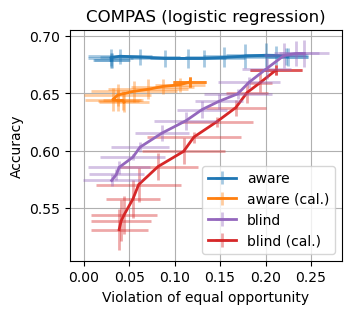

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.681996  0.007719   0.224155  0.023046
0.220  0.682249  0.007698   0.222622  0.024250
0.200  0.683260  0.008599   0.211338  0.035527
0.180  0.683386  0.010696   0.200155  0.044023
0.160  0.682628  0.010689   0.177335  0.045809
0.140  0.681491  0.008701   0.154631  0.043338
0.120  0.680606  0.007416   0.132201  0.045098
0.100  0.680606  0.008110   0.114418  0.041740
0.080  0.680606  0.007496   0.089466  0.038665
0.060  0.681870  0.006709   0.062091  0.043829
0.040  0.682502  0.006405   0.039885  0.035390
0.020  0.681238  0.007429   0.029788  0.024712
0.010  0.678838  0.006900   0.031116  0.019329
0.001  0.678838  0.006263   0.030246  0.019856

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.660013  0.004270   0.116655  0.017900
0.220  0.660013  0.004270   0.116655  0.017900
0.200  0.660013  0.004270   0.116655  0.017900
0.180  0.660013  0.004270   0.116655  0.017900
0.160  0.660013  0.004270   0.116655  0.017900
0.140  0.657612  0.006189   0.105572  0.027359
0.120  0.656096  0.006389   0.086722  0.034779
0.100  0.653696  0.008515   0.071233  0.043920
0.080  0.651927  0.009165   0.055323  0.046789
0.060  0.648642  0.009427   0.037480  0.036936
0.040  0.644725  0.010074   0.032006  0.030946
0.020  0.643841  0.008769   0.038132  0.022497
0.010  0.643967  0.008023   0.042911  0.022041
0.001  0.642451  0.008393   0.044334  0.027086

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.684902  0.011574   0.242624  0.027334
0.240  0.684902  0.010927   0.233772  0.025045
0.220  0.683260  0.010983   0.220491  0.022160
0.200  0.671762  0.009150   0.201237  0.026879
0.180  0.659760  0.004612   0.181849  0.033658
0.160  0.649653  0.004568   0.169278  0.037312
0.140  0.643083  0.006333   0.148547  0.026632
0.120  0.636008  0.007440   0.130243  0.027752
0.100  0.626279  0.007860   0.112581  0.034914
0.080  0.615414  0.006766   0.086023  0.029941
0.060  0.603159  0.004542   0.061966  0.032337
0.040  0.594441  0.002860   0.054094  0.035865
0.020  0.585471  0.005745   0.038916  0.033795
0.010  0.579533  0.004966   0.036093  0.030085
0.001  0.574100  0.005255   0.030805  0.031952

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.670120  0.004363   0.211160  0.028440
0.240  0.670120  0.004363   0.211160  0.028440
0.220  0.670246  0.004190   0.211160  0.028440
0.200  0.659507  0.008028   0.194068  0.012725
0.180  0.650790  0.008837   0.179635  0.022611
0.160  0.637650  0.006957   0.167227  0.033121
0.140  0.625395  0.004261   0.146423  0.040026
0.120  0.612003  0.004799   0.121211  0.051519
0.100  0.599495  0.011415   0.109905  0.045384
0.080  0.586229  0.011986   0.081769  0.044348
0.060  0.570436  0.014808   0.060418  0.046323
0.040  0.558054  0.016525   0.054224  0.029929
0.020  0.543904  0.016358   0.044320  0.035971
0.010  0.538850  0.017951   0.041229  0.033244
0.001  0.531270  0.018029   0.039026  0.031456

In [7]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

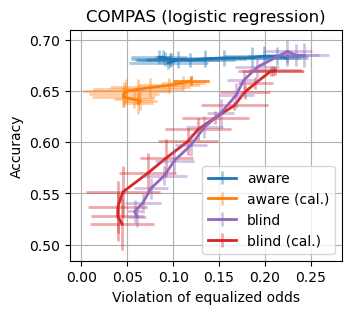

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.681996  0.007719  0.224155  0.023046
0.220  0.684018  0.009104  0.212925  0.032885
0.200  0.684144  0.010157  0.199035  0.043838
0.180  0.682502  0.010270  0.185741  0.052280
0.160  0.682375  0.007755  0.155684  0.049797
0.140  0.681491  0.008205  0.135025  0.044034
0.120  0.680354  0.007147  0.118171  0.049355
0.100  0.680985  0.006396  0.097155  0.042821
0.080  0.683007  0.006736  0.084617  0.030625
0.060  0.683007  0.006766  0.088506  0.008740
0.040  0.681364  0.006813  0.091485  0.019952
0.020  0.679975  0.007015  0.096856  0.038409
0.010  0.680354  0.008357  0.105115  0.044703
0.001  0.677322  0.005532  0.094583  0.043154

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.660013  0.004270  0.119695  0.019747
0.220  0.660013  0.004270  0.119695  0.019747
0.200  0.660013  0.004270  0.119695  0.019747
0.180  0.660013  0.004270  0.119695  0.019747
0.160  0.657865  0.006482  0.110688  0.024241
0.140  0.655464  0.007169  0.095479  0.034248
0.120  0.653443  0.009312  0.074697  0.043774
0.100  0.651548  0.009690  0.061893  0.048929
0.080  0.649779  0.011541  0.048897  0.047512
0.060  0.646620  0.011823  0.046182  0.037998
0.040  0.644093  0.009408  0.045865  0.034465
0.020  0.641946  0.008585  0.057086  0.021026
0.010  0.640430  0.009224  0.064098  0.018731
0.001  0.638029  0.010504  0.062009  0.016562

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.684902  0.011574  0.242624  0.027334
0.240  0.684902  0.010927  0.233772  0.025045
0.220  0.688692  0.010881  0.224541  0.026927
0.200  0.673405  0.010245  0.191734  0.023871
0.180  0.660265  0.008949  0.176674  0.017914
0.160  0.645989  0.012181  0.168662  0.018953
0.140  0.628174  0.013816  0.151621  0.014344
0.120  0.614782  0.010584  0.134123  0.020009
0.100  0.597473  0.010489  0.119658  0.017238
0.080  0.582059  0.012107  0.101419  0.021629
0.060  0.567277  0.009154  0.090285  0.024687
0.040  0.554896  0.010250  0.075765  0.018609
0.020  0.540745  0.009837  0.066973  0.019854
0.010  0.532407  0.011189  0.058082  0.008196
0.001  0.527227  0.010309  0.060884  0.009556

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.670120  0.004363  0.211160  0.028440
0.240  0.669488  0.004778  0.208357  0.033267
0.220  0.669615  0.004642  0.206669  0.036386
0.200  0.657612  0.005720  0.189688  0.019144
0.180  0.648768  0.006745  0.177753  0.027221
0.160  0.635881  0.004612  0.166777  0.036221
0.140  0.623879  0.006215  0.145801  0.036574
0.120  0.612634  0.010584  0.127230  0.035635
0.100  0.600758  0.012954  0.115931  0.032667
0.080  0.584586  0.018695  0.092352  0.028914
0.060  0.569678  0.020128  0.072121  0.031453
0.040  0.551485  0.025586  0.045289  0.039962
0.020  0.537081  0.025357  0.039816  0.032129
0.010  0.527606  0.023532  0.039572  0.028663
0.001  0.520278  0.025682  0.044377  0.034524

In [8]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.24, 0.22, 0.20, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04,
        0.02, 0.01, 0.001
    ],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (logistic regression)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

## Gradient boosting decision tree

In [9]:
# Train attribute-aware p(Y | X) predictor
predictor_y = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_y.fit(inputs_pretrain, labels_pretrain)

# Train attribute-blind p(A, Y | X) predictor
predictor_u_ay = lightgbm.LGBMClassifier(random_state=seed_pretrain)
predictor_u_ay.fit(inputs_u_pretrain, labels_ay_pretrain)

print(
    'Binned ECE of attribute-blind predictor:',
    utils.calibration_error(predictor_u_ay.predict_proba(inputs_u_),
                            groups_ * n_classes + labels_,
                            n_bins=n_bins_calib))

Binned ECE of attribute-blind predictor: 0.5428472237102137


In [10]:
# Precompute P(A, Y | X) on (test + post-processing) set for aware setting
probas_y_ = predictor_y.predict_proba(inputs_).reshape(-1, n_classes)
probas_ay_ = np.einsum("ij,ik->ijk", np.eye(n_groups)[groups_], probas_y_)

# Precompute P(A, Y | X) on (test + post-processing) set for blind setting
probas_ay_u_ = predictor_u_ay.predict_proba(inputs_u_).reshape(
    -1, n_groups, n_classes)

postprocess_kwargs = {
    'n_test': n_test,
    'n_classes': n_classes,
    'n_groups': n_groups,
    'labels': labels_,
    'groups': groups_,
    'probas_ay': probas_ay_,
    'max_workers': max_workers,
}
postprocess_u_kwargs = {**postprocess_kwargs, 'probas_ay': probas_ay_u_}

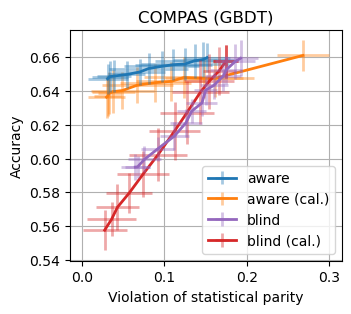

Results for attribute-aware setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.151550  0.027754
0.180  0.658497  0.010614  0.146973  0.036791
0.160  0.657738  0.009882  0.136442  0.048312
0.140  0.655843  0.009191  0.124692  0.053437
0.120  0.655464  0.009029  0.110850  0.046841
0.100  0.654454  0.009370  0.096418  0.045358
0.080  0.653190  0.009423  0.080770  0.047636
0.060  0.651169  0.007612  0.070200  0.030154
0.040  0.649653  0.007770  0.054357  0.022535
0.020  0.648768  0.009359  0.038892  0.020830
0.010  0.648389  0.009051  0.033509  0.021630
0.001  0.647126  0.008806  0.030998  0.024130

Results for attribute-aware setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.660897  0.009005  0.267966  0.031897
0.180  0.647378  0.011295  0.161558  0.046897
0.160  0.647378  0.011779  0.148004  0.047843
0.140  0.647884  0.012311  0.123479  0.047907
0.120  0.645610  0.011432  0.108270  0.043405
0.100  0.644852  0.011295  0.088999  0.043072
0.080  0.643335  0.010586  0.066921  0.043140
0.060  0.640177  0.011074  0.048888  0.037949
0.040  0.639545  0.012520  0.037917  0.026055
0.020  0.638661  0.012184  0.033010  0.013870
0.010  0.636766  0.011622  0.031042  0.016010
0.001  0.636260  0.012326  0.029679  0.022306

Results for attribute-blind setting:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.192264  0.020597
0.210  0.657359  0.010202  0.185813  0.024582
0.200  0.652306  0.007998  0.174644  0.019589
0.180  0.648895  0.009049  0.171581  0.021612
0.160  0.643209  0.008058  0.159820  0.016678
0.140  0.640430  0.008655  0.149967  0.013860
0.120  0.632849  0.007703  0.145472  0.018834
0.100  0.628048  0.007040  0.133090  0.017865
0.080  0.620973  0.008273  0.125806  0.019348
0.060  0.613266  0.008326  0.111990  0.017179
0.040  0.605685  0.006969  0.091750  0.019856
0.020  0.599495  0.007698  0.075686  0.020039
0.010  0.595073  0.006580  0.067293  0.015594
0.001  0.594946  0.007703  0.064565  0.017778

Results for attribute-blind setting with calibration:


accuracy            delta_sp          
           mean       std      mean       std
alpha                                        
inf    0.657359  0.009576  0.174266  0.014976
0.210  0.657359  0.009576  0.174266  0.014976
0.200  0.657359  0.009576  0.174266  0.014976
0.180  0.651800  0.014199  0.166336  0.020208
0.160  0.645610  0.016443  0.154054  0.030473
0.140  0.639166  0.018890  0.143516  0.034836
0.120  0.627037  0.018620  0.127170  0.032701
0.100  0.616298  0.017373  0.112248  0.031111
0.080  0.602274  0.015632  0.092183  0.035555
0.060  0.590903  0.013390  0.074199  0.031607
0.040  0.579785  0.011847  0.057405  0.027928
0.020  0.571194  0.013507  0.042859  0.026347
0.010  0.564119  0.010107  0.035796  0.029613
0.001  0.557675  0.011847  0.027395  0.026760

In [11]:
## Post-processing for statistical parity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [
        np.inf, 0.21, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [
        np.inf, 0.21, 0.2, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02,
        0.01, 0.001
    ],
    seeds,
    'sp',
    ['accuracy', 'delta_sp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_sp',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_sp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_sp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_sp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of statistical parity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

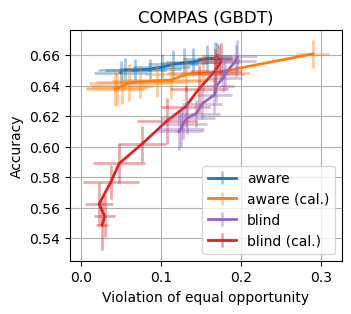

Results for attribute-aware setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659634  0.008468   0.169876  0.018247
0.160  0.657991  0.010726   0.166756  0.021288
0.140  0.657865  0.008873   0.157582  0.031057
0.120  0.655717  0.009045   0.140090  0.033921
0.100  0.655085  0.009570   0.127853  0.029208
0.080  0.654075  0.009312   0.114423  0.030857
0.060  0.652179  0.008576   0.100229  0.035177
0.040  0.651042  0.006664   0.086149  0.038720
0.020  0.650284  0.007483   0.067479  0.037850
0.010  0.650537  0.007895   0.054008  0.033053
0.001  0.648642  0.007690   0.049092  0.034003

Results for attribute-aware setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.660897  0.009005   0.289053  0.020779
0.160  0.648515  0.012156   0.167590  0.043284
0.140  0.648136  0.012027   0.151574  0.044418
0.120  0.647505  0.011493   0.131162  0.051968
0.100  0.643841  0.012422   0.112306  0.056265
0.080  0.643335  0.010405   0.094429  0.056546
0.060  0.642577  0.010451   0.072664  0.054069
0.040  0.641946  0.012072   0.059026  0.049482
0.020  0.639545  0.011359   0.050140  0.038744
0.010  0.638282  0.010726   0.044321  0.038381
0.001  0.637903  0.011436   0.042033  0.036033

Results for attribute-blind setting:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.659255  0.010500   0.194866  0.024466
0.180  0.656222  0.010432   0.192946  0.024923
0.160  0.647757  0.010014   0.179333  0.023504
0.140  0.645357  0.009408   0.177559  0.022973
0.120  0.640051  0.010918   0.168827  0.022522
0.100  0.633986  0.011991   0.166316  0.022367
0.080  0.628301  0.010014   0.151042  0.025011
0.060  0.621731  0.008758   0.143429  0.029860
0.040  0.618699  0.010054   0.132175  0.034558
0.020  0.615161  0.010200   0.127061  0.029653
0.010  0.611876  0.012416   0.124920  0.028206
0.001  0.609981  0.012432   0.121799  0.029827

Results for attribute-blind setting with calibration:


accuracy           delta_eopp          
           mean       std       mean       std
alpha                                         
inf    0.657359  0.009576   0.172044  0.026120
0.180  0.655717  0.012387   0.174444  0.023728
0.160  0.649905  0.014484   0.167504  0.031728
0.140  0.637903  0.015871   0.146924  0.036403
0.120  0.626279  0.013465   0.130295  0.030852
0.100  0.616930  0.015126   0.106977  0.037638
0.080  0.601895  0.011694   0.075993  0.030325
0.060  0.589008  0.012819   0.047243  0.032502
0.040  0.576753  0.011256   0.036742  0.035284
0.020  0.562350  0.014086   0.022127  0.017315
0.010  0.554264  0.013794   0.029121  0.012881
0.001  0.548452  0.016445   0.025847  0.007942

In [12]:
## Post-processing for equal opportunity

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eopp',
    ['accuracy', 'delta_eopp'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eopp',
                   'accuracy',
                   label='aware',
                   zorder=10)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eopp',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=20)
utils.plot_results(ax,
                   df_blind,
                   'delta_eopp',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eopp',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equal opportunity")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)

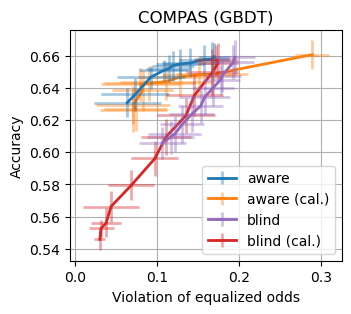

Results for attribute-aware setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659634  0.008468  0.169876  0.018247
0.160  0.657991  0.010726  0.166756  0.021288
0.140  0.657865  0.008873  0.157582  0.031057
0.120  0.655717  0.009045  0.140090  0.033921
0.100  0.655085  0.009570  0.128031  0.028893
0.080  0.654075  0.009312  0.119348  0.025626
0.060  0.652179  0.008576  0.114204  0.027740
0.040  0.651042  0.006664  0.108026  0.030193
0.020  0.646873  0.007189  0.092331  0.041676
0.010  0.636134  0.010274  0.073541  0.041613
0.001  0.630954  0.008961  0.063651  0.040662

Results for attribute-aware setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.660897  0.009005  0.289053  0.020779
0.160  0.648642  0.011948  0.167220  0.043587
0.140  0.648389  0.011602  0.150835  0.044997
0.120  0.646999  0.011617  0.128557  0.051508
0.100  0.644093  0.011739  0.110441  0.055428
0.080  0.643083  0.010767  0.090715  0.055884
0.060  0.642451  0.010284  0.079824  0.048209
0.040  0.638661  0.012846  0.082379  0.037372
0.020  0.629564  0.011602  0.071185  0.045158
0.010  0.626911  0.013390  0.074009  0.038155
0.001  0.626532  0.013691  0.070965  0.040753

Results for attribute-blind setting:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.659255  0.010500  0.194866  0.024466
0.180  0.656222  0.010432  0.192946  0.024923
0.160  0.647757  0.010014  0.179333  0.023504
0.140  0.645357  0.009408  0.177559  0.022973
0.120  0.640303  0.011472  0.168534  0.025897
0.100  0.634365  0.011189  0.158028  0.030629
0.080  0.628932  0.010623  0.153209  0.027323
0.060  0.623752  0.011047  0.142106  0.027633
0.040  0.617435  0.011619  0.130721  0.026573
0.020  0.611497  0.011380  0.121685  0.032205
0.010  0.609476  0.010316  0.116456  0.028739
0.001  0.605685  0.009882  0.106290  0.028464

Results for attribute-blind setting with calibration:


accuracy            delta_eo          
           mean       std      mean       std
alpha                                        
inf    0.657359  0.009576  0.172044  0.026120
0.180  0.655717  0.012387  0.174444  0.023728
0.160  0.649905  0.014484  0.167504  0.031728
0.140  0.635629  0.013011  0.145652  0.034856
0.120  0.622994  0.010621  0.135329  0.035041
0.100  0.609602  0.011023  0.110867  0.030114
0.080  0.596210  0.010724  0.097399  0.028736
0.060  0.579533  0.009248  0.068723  0.027851
0.040  0.566267  0.009440  0.043996  0.034661
0.020  0.556033  0.009049  0.038033  0.018300
0.010  0.552622  0.005349  0.031863  0.015330
0.001  0.545799  0.006774  0.030356  0.006729

In [13]:
## Post-processing for equalized odds

df_aware = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_kwargs,
)
df_aware_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_kwargs,
)
df_blind = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    **postprocess_u_kwargs,
)
df_blind_cal = utils.postprocess_and_evaluate(
    [np.inf, 0.18, 0.16, 0.14, 0.12, 0.1, 0.08, 0.06, 0.04, 0.02, 0.01, 0.001],
    seeds,
    'eo',
    ['accuracy', 'delta_eo'],
    calibrator_factory=calibrator_factory,
    **postprocess_u_kwargs,
)

fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))
utils.plot_results(ax,
                   df_aware,
                   'delta_eo',
                   'accuracy',
                   label='aware',
                   zorder=20)
utils.plot_results(ax,
                   df_aware_cal,
                   'delta_eo',
                   'accuracy',
                   label='aware (cal.)',
                   zorder=10)
utils.plot_results(ax,
                   df_blind,
                   'delta_eo',
                   'accuracy',
                   label='blind',
                   color='tab:purple',
                   zorder=40)
utils.plot_results(ax,
                   df_blind_cal,
                   'delta_eo',
                   'accuracy',
                   label='blind (cal.)',
                   color='tab:red',
                   zorder=30)
ax.set_xlabel("Violation of equalized odds")
ax.set_ylabel("Accuracy")
ax.set_title("COMPAS (GBDT)")
ax.legend()
plt.show()

print("Results for attribute-aware setting:")
display(df_aware)
print("Results for attribute-aware setting with calibration:")
display(df_aware_cal)
print("Results for attribute-blind setting:")
display(df_blind)
print("Results for attribute-blind setting with calibration:")
display(df_blind_cal)